# Predicting Home Prices Using Neural Networks & Melissa Data

## By: Seth Abuhamdeh, Christopher Effarah, Matthew Eimers, Vincent Ramos

In [116]:
import csv
import matplotlib.pyplot as plt
import pandas as pd
import altair as alt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from scipy.optimize import curve_fit
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from keras.models import Sequential
from keras.layers import Dense

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

### Data Cleaning

In [2]:
df_raw_PropAssess = pd.read_csv("/work/PropertyAssessmentData.csv")

In [3]:
# Data Cleaning
df_single_family = df_raw_PropAssess[df_raw_PropAssess['CountyLandUseDescription'] == 'SINGLE FAMILY RESIDENTIAL']
df_filtered = df_single_family[df_single_family['LotSizeAreaUnit'] != 'AC']
columns_to_drop = ['Suite', 'CountyLandUseDescription', 'RecordId', 'MAK', 'LotSizeAreaUnit', 'ZipCodePlus4', 'FIPSCode', 'APN', 'CensusKey', 'CensusKeyDecennial', 'NumberOfUnits', 'HasDeck', 'DeckArea','HasGuestHouse', 'PoolArea', 'NumberOfBuildings', 'HasBasement','HasElevator','GuestHouseArea', 'HasFireplace', 'HasSprinklers', 'HasSecurityAlarm' ]
df_final = df_filtered.drop(columns=columns_to_drop)
air_conditioning_map = {
    'L': 0, 'N': 0, 'W': 1, 'Y': 1, 'C': 1
}
df_final['AirConditioning'] = df_final['AirConditioning'].map(air_conditioning_map).fillna(0)
df_final['GarageTypeParking'] = df_final['GarageTypeParking'].fillna(0)
df_final['PoolType'] = df_final['PoolType'].fillna(0)
df_final['YearBuilt'] = 2024 - df_final['YearBuilt']
df_final.rename(columns={'YearBuilt': 'HomeAge'}, inplace=True)
df_final = df_final.dropna(subset=['HomeAge'])   # Only 9 homes had missing 
df_final = df_final.dropna(subset=['HomeAge']) 
mean_value = round(df_final['NumberOfStories'].mean())
df_final['NumberOfStories'] = df_final['NumberOfStories'].fillna(mean_value)
df_final['NumberOfStories'].head()


df_final_shuffle = df_final.sample(frac=1)
df_final_smol = df_final_shuffle.head(2000)
df_final.head()

,PropertyAddress,City,State,ZipCode,Latitude,Longitude,TotalAssessedValue,AssessmentYear,LotSizeOrArea,SalesPriceFromAssessment,...,TotalNumberOfRooms,NumberOfBedrooms,NumberOfBaths,NumberOfPartialBaths,NumberOfStories,GarageTypeParking,GarageParkingNumberOfCars,PoolType,AirConditioning,FireplaceCount
0,1806 W 19th St,Santa Ana,CA,92706,33.761373,-117.894009,280428,2023,6050.0,197500,...,4,2,1.0,0,1.0,999.0,1,0.0,0.0,0
1,1805 English St,Santa Ana,CA,92706,33.760957,-117.896340,663188,2023,6000.0,495000,...,5,3,1.0,0,3.0,999.0,2,0.0,0.0,1
2,1915 W 18th St,Santa Ana,CA,92706,33.761019,-117.895730,680000,2023,6352.0,535000,...,5,3,1.0,0,1.0,999.0,2,0.0,0.0,0
3,1922 W 18th St,Santa Ana,CA,92706,33.760542,-117.895991,323024,2023,6025.0,227500,...,5,3,1.0,0,1.0,999.0,2,0.0,0.0,0
4,1826 W 18th St,Santa Ana,CA,92706,33.760550,-117.894824,147362,2023,6025.0,3000,...,4,2,1.0,0,1.0,999.0,1,0.0,0.0,1


In [14]:
df_raw_ZipData = pd.read_csv("/work/ZipData.csv")

In [147]:
# Selecting Columns to Keep
columns_to_keep = [
    'ZipCode','PopulationWhite',
    'PopulationAfricanAmerican', 'PopulationAmericanIndianAlaskaNative', 'PopulationAsian',
    'PopulationHispanic', 'PopulationPacificIslander', 'PopulationOther', 'PopulationMultipleRace'
]
Zip_Clean = df_raw_ZipData[columns_to_keep]
Zip_Clean['TotalPopulationCalculated'] = Zip_Clean[[
    'PopulationWhite', 'PopulationAfricanAmerican', 'PopulationAmericanIndianAlaskaNative',
    'PopulationAsian', 'PopulationHispanic', 'PopulationPacificIslander', 'PopulationOther',
    'PopulationMultipleRace'
]].sum(axis=1)
Zip_Clean = Zip_Clean.drop_duplicates(subset='ZipCode')


# Produce Zip of the clean data
Zip_Clean.head()


/tmp/ipykernel_137/1511921548.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Zip_Clean['TotalPopulationCalculated'] = Zip_Clean[[


,ZipCode,PopulationWhite,PopulationAfricanAmerican,PopulationAmericanIndianAlaskaNative,PopulationAsian,PopulationHispanic,PopulationPacificIslander,PopulationOther,PopulationMultipleRace,TotalPopulationCalculated
0,90620,21260,743,512,14032,16730,96,4764,5697,63834
1,90621,12955,1471,530,13111,15873,83,5326,2909,52258
2,90623,5209,722,42,7520,3086,0,711,1499,18789
4,90630,22410,1358,368,19270,9882,96,2880,4161,60425
5,90631,34538,1600,662,8853,39777,30,16049,7869,109378


In [4]:
# Returns Distance in Kilometers with Vectors
def latlong_distance(id1, id2):
  lat1 = df_final.at[id1, "Latitude"]
  lat2 = df_final.at[id2, "Latitude"]

  lon1 = df_final.at[id1, "Longitude"]
  lon2 = df_final.at[id2, "Longitude"]

  return math.acos(math.sin(lat1)*math.sin(lat2)+math.cos(lat1)*math.cos(lat2)*math.cos(lon2-lon1))*6371

array([      0.,   20000.,   40000.,   60000.,   80000.,  100000.,
        120000.,  140000.,  160000.,  180000.,  200000.,  220000.,
        240000.,  260000.,  280000.,  300000.,  320000.,  340000.,
        360000.,  380000.,  400000.,  420000.,  440000.,  460000.,
        480000.,  500000.,  520000.,  540000.,  560000.,  580000.,
        600000.,  620000.,  640000.,  660000.,  680000.,  700000.,
        720000.,  740000.,  760000.,  780000.,  800000.,  820000.,
        840000.,  860000.,  880000.,  900000.,  920000.,  940000.,
        960000.,  980000., 1000000.])

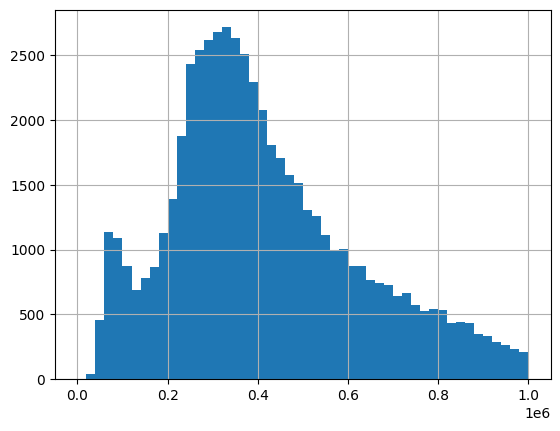

In [5]:
df_final['TotalAssessedValue'].hist(bins = np.linspace(0, 1000000, 51))
np.linspace(0, 1000000, 51)

### Creating a Heat Map With the Base Data

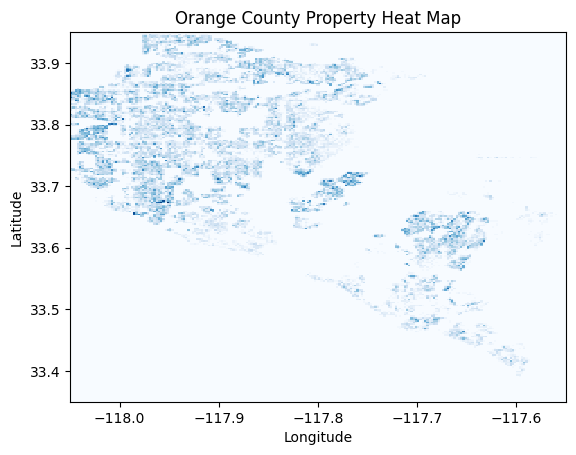

In [6]:
res_factor = 20
lats = df_final["Latitude"].values;
longs = df_final["Longitude"].values;

lat_bins = np.linspace(33.35, 33.95, 12*res_factor + 1);
long_bins = np.linspace(-118.05, -117.55, 11*res_factor + 1);
plt.title('Orange County Property Heat Map')
plt.ylabel('Latitude')
plt.xlabel('Longitude')

plt.hist2d(longs, lats, bins=(long_bins, lat_bins), cmap='Blues');

### Creating the Neural Network

In [29]:
def get_model(group, bins):

    group_length = len(group["Latitude"].values)

    model = Sequential([
        Dense(32, activation='relu', input_shape=(10,)),
        Dense(32, activation='relu'),
        Dense(bins + 1, activation='softmax'),
    ])
    model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

    cols = ['LotSizeOrArea','HomeAge', 'TotalNumberOfRooms','NumberOfBedrooms', 'NumberOfBaths', 'NumberOfPartialBaths','NumberOfStories', 'GarageParkingNumberOfCars','AirConditioning', 'FireplaceCount'];

    #sample_rows = df_final.sample(n=2500)
    sample_rows = group.sample(n= group_length // 2)

    X = sample_rows[cols];
    Y = sample_rows["TotalAssessedValue"]
    Y_new = []
    for i in Y:
        yval = math.floor(i / (2000000 / bins)) / bins
        if yval > 1:
            Y_new.append(1)
        else:
            Y_new.append(yval)

    one_hot_vectors = [convert_to_one_hot(value, bins + 1) for value in Y_new]
    # Convert the list of vectors to a numpy array
    Y = np.array(one_hot_vectors)

    min_max_scaler = preprocessing.MinMaxScaler()
    X_scale = min_max_scaler.fit_transform(X)

    X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X_scale, Y, test_size=0.3)
    X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5)
    
    hist = model.fit(X_train, Y_train,
          batch_size=32, epochs=50,
          validation_data=(X_val, Y_val));
    return model, hist.history['accuracy'][-1]

In [128]:
def convert_to_one_hot(value, output_dim):
    index = int(value * (output_dim - 1))
    one_hot = np.zeros(output_dim)
    one_hot[index] = 1
    return one_hot

In [31]:
grouped = df_final.groupby('ZipCode')

modeled_zips = []
all_models = []
all_accuracies = []

# Get groups
#anaheim_group = 0;
for category, group in grouped:
    print("ZipCode:", category)
    group_lats = group["Latitude"].values;
    group_longs = group["Longitude"].values;

    if len(group_lats) >= 250:
        modeled_zips.append(category)
        zip_model, accuracy = get_model(group, 10)
        
        all_models.append(zip_model)
        all_accuracies.append(accuracy)


    #plt.hist2d(group_longs, group_lats, bins=(long_bins, lat_bins), cmap='Blues');
    #plt.show()
    #print(f'Included Data Size: {len(group_lats)}')

5/5 [==============================] - 0s 15ms/step - loss: 0.6524 - accuracy: 0.1189 - val_loss: 0.6523 - val_accuracy: 0.0968
Epoch 7/50
5/5 [==============================] - 0s 14ms/step - loss: 0.6496 - accuracy: 0.1189 - val_loss: 0.6495 - val_accuracy: 0.0968
Epoch 8/50
5/5 [==============================] - 0s 34ms/step - loss: 0.6468 - accuracy: 0.1189 - val_loss: 0.6467 - val_accuracy: 0.0968
Epoch 9/50
5/5 [==============================] - 0s 26ms/step - loss: 0.6439 - accuracy: 0.1189 - val_loss: 0.6439 - val_accuracy: 0.0968
Epoch 10/50
5/5 [==============================] - 0s 43ms/step - loss: 0.6411 - accuracy: 0.1189 - val_loss: 0.6410 - val_accuracy: 0.0968
Epoch 11/50
5/5 [==============================] - 0s 19ms/step - loss: 0.6382 - accuracy: 0.1189 - val_loss: 0.6382 - val_accuracy: 0.0968
Epoch 12/50
5/5 [==============================] - 0s 24ms/step - loss: 0.6354 - accuracy: 0.1189 - val_loss: 0.6353 - val_accuracy: 0.0968
Epoch 13/50
5/5 [==================

### Points Graphed

Text(0.5, 1.0, 'Accuracy of Fit Versus Total Size of ZIP Code Inclusions in Data')

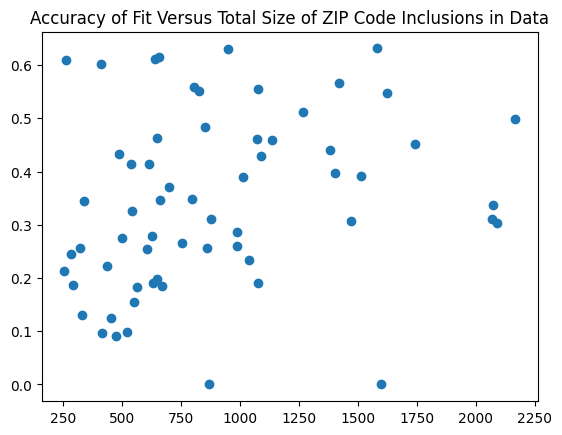

In [67]:
haha_pops = []
haha_accuracies = []

for category in grouped:
    try:
        zin = modeled_zips.index(category[0])
        zpop = len(category[1]['Latitude'].values)
        haha_pops.append(zpop)
        haha_accuracies.append(all_accuracies[zin])
    except:
        pass

plt.scatter(haha_pops, haha_accuracies)q
plt.title("Accuracy of Fit Versus Total Size of ZIP Code Inclusions in Data")

### Linear Line of Best Fit

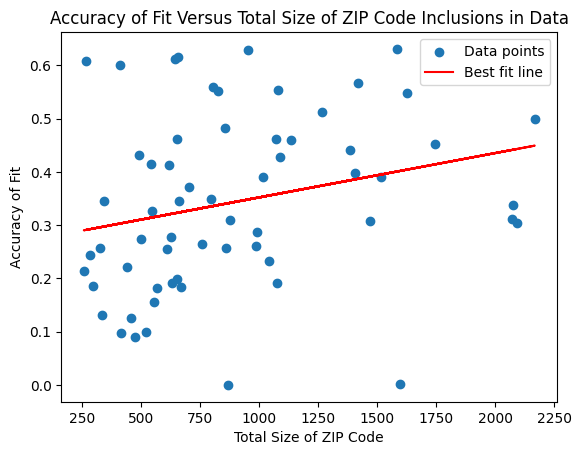

In [135]:
import matplotlib.pyplot as plt
import numpy as np

haha_pops = []
haha_accuracies = []

for category in grouped:
    try:
        zin = modeled_zips.index(category[0])
        zpop = len(category[1]['Latitude'].values)
        haha_pops.append(zpop)
        haha_accuracies.append(all_accuracies[zin])
    except:
        pass


haha_pops = np.array(haha_pops)
haha_accuracies = np.array(haha_accuracies)
slope, intercept = np.polyfit(haha_pops, haha_accuracies, 1)
best_fit_line = slope * haha_pops + intercept

# Plotting
plt.scatter(haha_pops, haha_accuracies, label='Data points')
plt.plot(haha_pops, best_fit_line, color='red', label='Best fit line') 
plt.title("Accuracy of Fit Versus Total Size of ZIP Code Inclusions in Data")
plt.xlabel("Total Size of ZIP Code")
plt.ylabel("Accuracy of Fit")
plt.legend()  
plt.show()


### Logarithmic Line of Best Fit

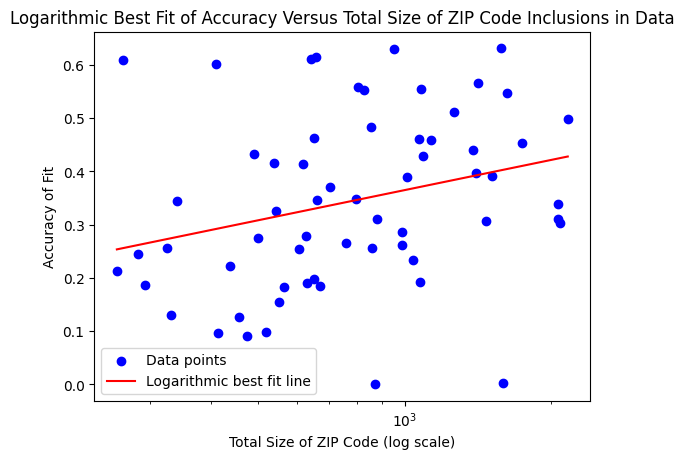

In [140]:
import matplotlib.pyplot as plt
import numpy as np

haha_pops = []
haha_accuracies = []

for category in grouped:
    try:
        zin = modeled_zips.index(category[0])
        zpop = len(category[1]['Latitude'].values)
        haha_pops.append(zpop)
        haha_accuracies.append(all_accuracies[zin])
    except:
        pass

haha_pops = np.array(haha_pops)
haha_accuracies = np.array(haha_accuracies)
mask = haha_pops > 0
haha_pops = haha_pops[mask]
haha_accuracies = haha_accuracies[mask]
log_haha_pops = np.log(haha_pops)
slope, intercept = np.polyfit(log_haha_pops, haha_accuracies, 1)
best_fit_line = slope * log_haha_pops + intercept
sorted_indices = np.argsort(haha_pops)
sorted_haha_pops = haha_pops[sorted_indices]
sorted_best_fit_line = best_fit_line[sorted_indices]

# Plotting
plt.scatter(haha_pops, haha_accuracies, label='Data points', color='blue')
plt.plot(sorted_haha_pops, sorted_best_fit_line, color='red', label='Logarithmic best fit line')  # Plot on original x-scale
plt.xscale('log')  # Applying log scale to x-axis
plt.title("Logarithmic Best Fit of Accuracy Versus Total Size of ZIP Code Inclusions in Data")
plt.xlabel("Total Size of ZIP Code (log scale)")
plt.ylabel("Accuracy of Fit")
plt.legend()
plt.show()


### Graph of Neural Network Accuracy Based off of Population Data

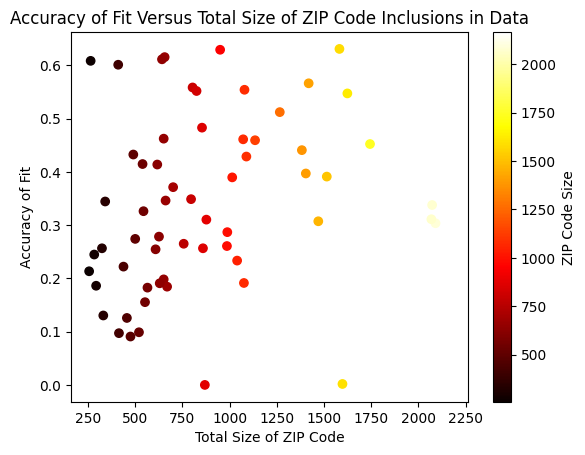

In [75]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

haha_pops = []
haha_accuracies = []
colors = []

for category in grouped:
    try:
        zin = modeled_zips.index(category[0])
        zpop = len(category[1]['Latitude'].values)
        haha_pops.append(zpop)
        haha_accuracies.append(all_accuracies[zin])
        colors.append(zpop)  # Add population as a color indicator
    except:
        pass

# Normalize the color data
norm = mcolors.Normalize(vmin=min(colors), vmax=max(colors))
cmap = plt.get_cmap('hot')  # Choose a colormap

plt.scatter(haha_pops, haha_accuracies, c=colors, cmap=cmap, norm=norm)
plt.colorbar(label='ZIP Code Size')  # Show a color bar
plt.title("Accuracy of Fit Versus Total Size of ZIP Code Inclusions in Data")
plt.xlabel("Total Size of ZIP Code")
plt.ylabel("Accuracy of Fit")
plt.show()


In [165]:
cols = ['LotSizeOrArea','HomeAge', 'TotalNumberOfRooms','NumberOfBedrooms', 'NumberOfBaths', 'NumberOfPartialBaths','NumberOfStories', 'GarageParkingNumberOfCars','AirConditioning', 'FireplaceCount'];

all_predicted_Y = []

prediction_sample = df_final.sample(n=1)
data_for_prediction = prediction_sample[cols]
for model_ex in all_models:
    predicted_Y = model_ex.predict(data_for_prediction)
    all_predicted_Y.append(predicted_Y)



1/1 [==============================] - 0s 22ms/step


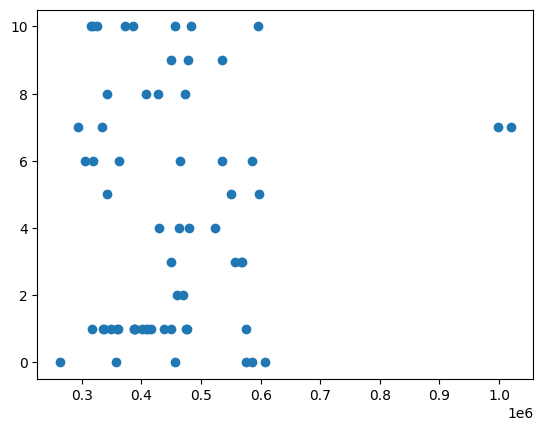

In [166]:
import statistics


cats = [get_index_of_one(pre) for pre in all_predicted_Y]

haha_means = []

for category in grouped:
    try:
        zin = modeled_zips.index(category[0])
        zmed = statistics.mean(category[1]['TotalAssessedValue'].values)
        haha_means.append(zmed)
    except:
        pass

plt.scatter(haha_means, cats)


In [159]:
print(len(zmed))

TypeError: object of type 'numpy.int64' has no len()

In [137]:
def get_index_of_one(vector):
    # Round each element of the vector
    rounded_vector = np.round(vector)
    # Find the index of the '1' in the rounded vector
    index_of_one = np.where(rounded_vector == 1)[1][0]
    return index_of_one

### Bar Graph Showing the Average Price of a House in Each ZipCode

In [46]:
alt.data_transformers.disable_max_rows()
color_scale = alt.Scale(
    domain=list(df_final_smol['ZipCode'].unique()),
    range=['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00', '#cab2d6', '#6a3d9a']
)
alt.Chart(df_final_smol).mark_bar().encode(
    x = "ZipCode:N",
    y = "mean(TotalAssessedValue)",
    color=alt.Color('ZipCode:N', scale=color_scale), 
    tooltip = "mean(TotalAssessedValue)"
).properties(
    title = "Average House Price In Each ZipCode"
)

/shared-libs/python3.9/py/lib/python3.9/site-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c11213eb-4caf-43af-a704-6d7886ef9cac' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>